In [2]:
import pickle, csv, random
import numpy as np
import pandas as pd
import statistics as s
from itertools import product
from math import floor
from tqdm import trange
from scipy.stats import bernoulli
import networkx as nx
from NNetwork import NNetwork as nn
from NNetwork.NNetwork import NNetwork

from sklearn import svm, metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from karateclub import Graph2Vec, Node2Vec
from SDL.src.SDL_BCD import SDL_BCD

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_graph = pickle.load(open('../data/random_graph/nws_20walk_graph.pkl', 'rb'))
df_dynamics = pd.read_csv("../data/dynamics_pairs/fca_k8_nws_20walk_dynamics.csv")
y = df_dynamics.y
base = df_dynamics.baseline_width
df_dynamics = df_dynamics.loc[:, 's1_1':'s50_20']
df = pd.read_csv("../data/dynamics_pairs/fca_k8_nws_20walk_colored_adj.csv")

In [4]:
# merge true adj and colored adj side by side
scale = 4 # scale down colored adj
X = pd.concat([pd.DataFrame(df_graph.T), df/scale], axis=1)

# SDL on colored adj

In [5]:
Y_data = y
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X.values, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

In [7]:
X_train

array([[0.  , 1.  , 0.  , ..., 0.25, 0.25, 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , ..., 0.  , 0.25, 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 0.25, 0.25, 0.  ]])

In [6]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 2
SDL_BCD_class_new = SDL_BCD(X=[X_train.T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SDL_BCD_class_new.fit(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  0%|          | 0/100 [00:00<?, ?it/s]

initial loading beta [[ 0.89934906  0.69552045 -0.97713564]]


  7%|▋         | 7/100 [00:44<09:48,  6.32s/it]


KeyboardInterrupt: 

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix_dynamics = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_matrix_dynamics)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [ ]:
Y_data = y
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(pd.concat([df_dynamics, base], axis=1, join='inner').copy(), Y_data)
Y_baseline = X_res.baseline_width
Y_data = y_res

#baseline model
length = len(Y_baseline[Y_baseline==False])
Y_baseline[random.sample(list(Y_baseline[Y_baseline==False].index),length//2)] = True
conf_matrix_baseline = confusion_matrix(y_true=Y_data, y_pred=Y_baseline)
print(conf_matrix_baseline)
print('Precision: %.3f' % precision_score(Y_data, Y_baseline))
print('Recall: %.3f' % recall_score(Y_data, Y_baseline))
print('F1: %.3f' % f1_score(Y_data, Y_baseline))
print('Accuracy: %.3f' % accuracy_score(Y_data, Y_baseline))

In [10]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 2,
 'loading': [array([[1.62198517e-54, 0.00000000e+00],
         [1.05780202e-02, 1.46507862e-02],
         [2.92322751e-03, 4.80009857e-03],
         ...,
         [4.44911889e-03, 9.29104448e-05],
         [2.88853825e-03, 1.09926718e-04],
         [3.47114165e-53, 0.00000000e+00]]),
  array([[-0.90785475, -0.39845912,  0.69304391]])],
 'code': array([[40.81472858, 27.9736575 , 67.67189283, ..., 59.40696129,
          0.        , 52.54045573],
        [27.45182702, 37.24437509, 25.02804192, ..., 22.92297962,
         56.86900603, 23.41543021]]),
 'iter': 100,
 'dict_update_freq': 1,
 'Training_threshold': 0.5877046606375862,
 'code_test': array([[31.70360856, 39.17917911, 53.34888387, ..., 50.07809425,
         39.47989244, 54.30394691],
        [25.6893913 , 26.42149401, 29.22419223, ..., 30.93168632,
         26.05059242, 29.05458321]]),
 'P_pred': array([[0.98612137],
   

In [ ]:
pickle.dump(results_dict_new, open('temp.pkl', 'wb'))

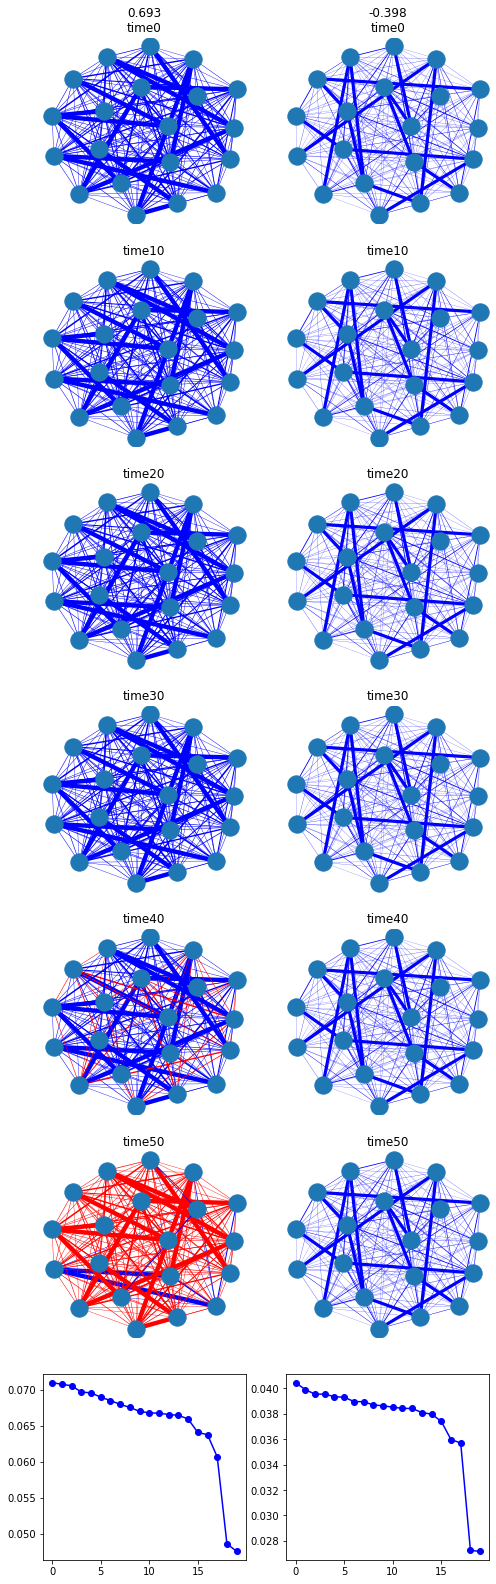

In [12]:
ncol = r
nrow = 6+1
num_nodes = 20
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
sorted_indices = np.argsort(results_dict_new["loading"][1][0][1:])[::-1]
for i in range(ncol):
    ind = sorted_indices[i]
    
    #learned adjacency matrix
    df_adj = pd.DataFrame(results_dict_new["loading"][0].T[ind][0:400].reshape(-1, 20))
    G = nx.from_pandas_adjacency(df_adj)
    edges = G.edges()
    weights = [300*G[u][v]['weight'] for u,v in edges] #weight of learned adjacency matrix
    
    deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
    axs[6, i].plot(deg_seq, "b-", marker="o")
        
    
    for j in range(nrow-1):
        col_adj = results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20)
        
        G1 = nx.Graph()
        for a in range(num_nodes):
            for b in range(num_nodes):
                u = list(G.nodes())[a]
                v = list(G.nodes())[b]
                if G.has_edge(u,v) and u!=v:
                    if col_adj[u, v] == 0: #all synchronizing edges
                        G1.add_edge(u,v, color='r')
                    else:
                        G1.add_edge(u,v, color='b')
        
        edges = G1.edges()
        colors = [G1[u][v]['color'] for u,v in edges]
        nx.draw(G1, edge_color=colors,width=weights, ax=axs[j, i], pos = nx.spring_layout(G1, seed=123))
        
        
        
        #sns.heatmap(results_dict_new["loading"][0].T[ind][0+j*10*400:400+j*10*400].reshape(-1, 20),
                    #ax = axs[j, i])
        if j == 0:
            axs[j, i].title.set_text(str(round(results_dict_new["loading"][1][0][1:][sorted_indices[i]], 3))
                                 +"\ntime"+str(j*10))
        else:
            axs[j, i].title.set_text("time"+str(j*10))

        
    #rect = plt.Rectangle((0.12+i*0.1, 0.12), 0.09, 0.78, fill=False, color="k", lw=1, 
                         #zorder=1000, transform=fig.transFigure, figure=fig)
    #fig.patches.extend([rect])

In [13]:
fig.savefig("temp.jpg")

# <B, WT> examples

In [46]:
#https://www.geeksforgeeks.org/implementation-of-logistic-regression-from-scratch-using-python/
class LogitRegression() :
    def __init__( self, learning_rate, iterations ) :        
        self.learning_rate = learning_rate        
        self.iterations = iterations
          
    # Function for model training    
    def fit( self, X, Y ) :        
        # no_of_training_examples, no_of_features        
        self.m, self.n = X.shape 
        # weight initialization        
        self.W = np.zeros( self.n )        
        self.b = 0        
        self.X = X        
        self.Y = Y
          
        # gradient descent learning
                  
        for i in range( self.iterations ) :            
            self.update_weights()  
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights( self ) :           
        A = 1 / ( 1 + np.exp( - ( self.X.dot( self.W ) + self.b ) ) )
          
        # calculate gradients        
        tmp = ( A - self.Y.T )        
        tmp = np.reshape( tmp, self.m )        
        dW = np.dot( self.X.T, tmp ) / self.m         
        db = np.sum( tmp ) / self.m 
          
        # update weights    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db
          
        return self
      
    # Hypothetical function  h( x ) 
      
    def predict( self, X ) :    
        Z = 1 / ( 1 + np.exp( - ( X.dot( self.W ) + self.b ) ) )        
        Y = np.where( Z > 0.5, 1, 0 )        
        return Y
    
    def predict_prob( self, X ) :    
        Z = 1 / ( 1 + np.exp( - ( X.dot( self.W ) + self.b ) ) )             
        return Z

In [52]:
df_features = pd.read_csv("../data/random_graph/nws_20walk_graph_features.csv")
results_dict_new = pickle.load(open('../data/dynamics_pairs/fca_k8_nws_20walk_colored_adj_sdl_dict.pkl', 'rb'))
coef_idx = np.argsort(results_dict_new["loading"][1][0][1:])[::-1] #sorted index for logistic reg coef of dict
ind = set(base.loc[base==False].index).intersection(y_train.index) #not concentrated index in the training set
print(df_features.loc[y_train.index, :].num_edges.idxmax())
print(df_features.loc[y_train.index, :].num_clique.idxmax())
print(df_features.loc[y_train.index, :].diameter.idxmin())
print(df_features.loc[y_train.index, :].num_edges.idxmin())
print(df_features.loc[y_train.index, :].diameter.idxmin())
print(df_features.loc[y_train.index, :].num_clique.idxmin())

4005
4005
4005
94
4005
1792


In [42]:
coef_idx

array([1, 0, 2, 5, 6, 3, 7, 4])

True :  [1]
[7. 0. 1. 1. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[0.57583514]
[0.55900075]
[0.53521938]
False :  [0]
[0. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 4.]
[0.42570973]
[0.43544979]
[0.4525787]
False :  [0]
[3. 3. 3. 3. 3. 3. 3. 3. 5. 5. 6. 7. 7. 0. 1. 1. 2. 3. 4. 4.]
[0.41578806]
[0.44347501]
[0.4716044]
False :  [0]
[2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 0. 7. 2. 2. 7. 7. 6. 4. 3. 3.]
[0.42617528]
[0.44761419]
[0.46463267]
False :  [0]
[4. 2. 2. 2. 2. 2. 2. 4. 4. 2. 2. 2. 4. 4. 2. 3. 3. 1. 7. 6.]
[0.42405459]
[0.42998535]
[0.45120902]
True :  [1]
[7. 0. 1. 1. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[0.57583514]
[0.55900075]
[0.53521938]
False :  [0]
[0. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 4.]
[0.42570973]
[0.43544979]
[0.4525787]
False :  [0]
[3. 3. 3. 3. 3. 3. 3. 3. 5. 5. 6. 7. 7. 0. 1. 1. 2. 3. 4. 4.]
[0.41578806]
[0.44347501]
[0.4716044]


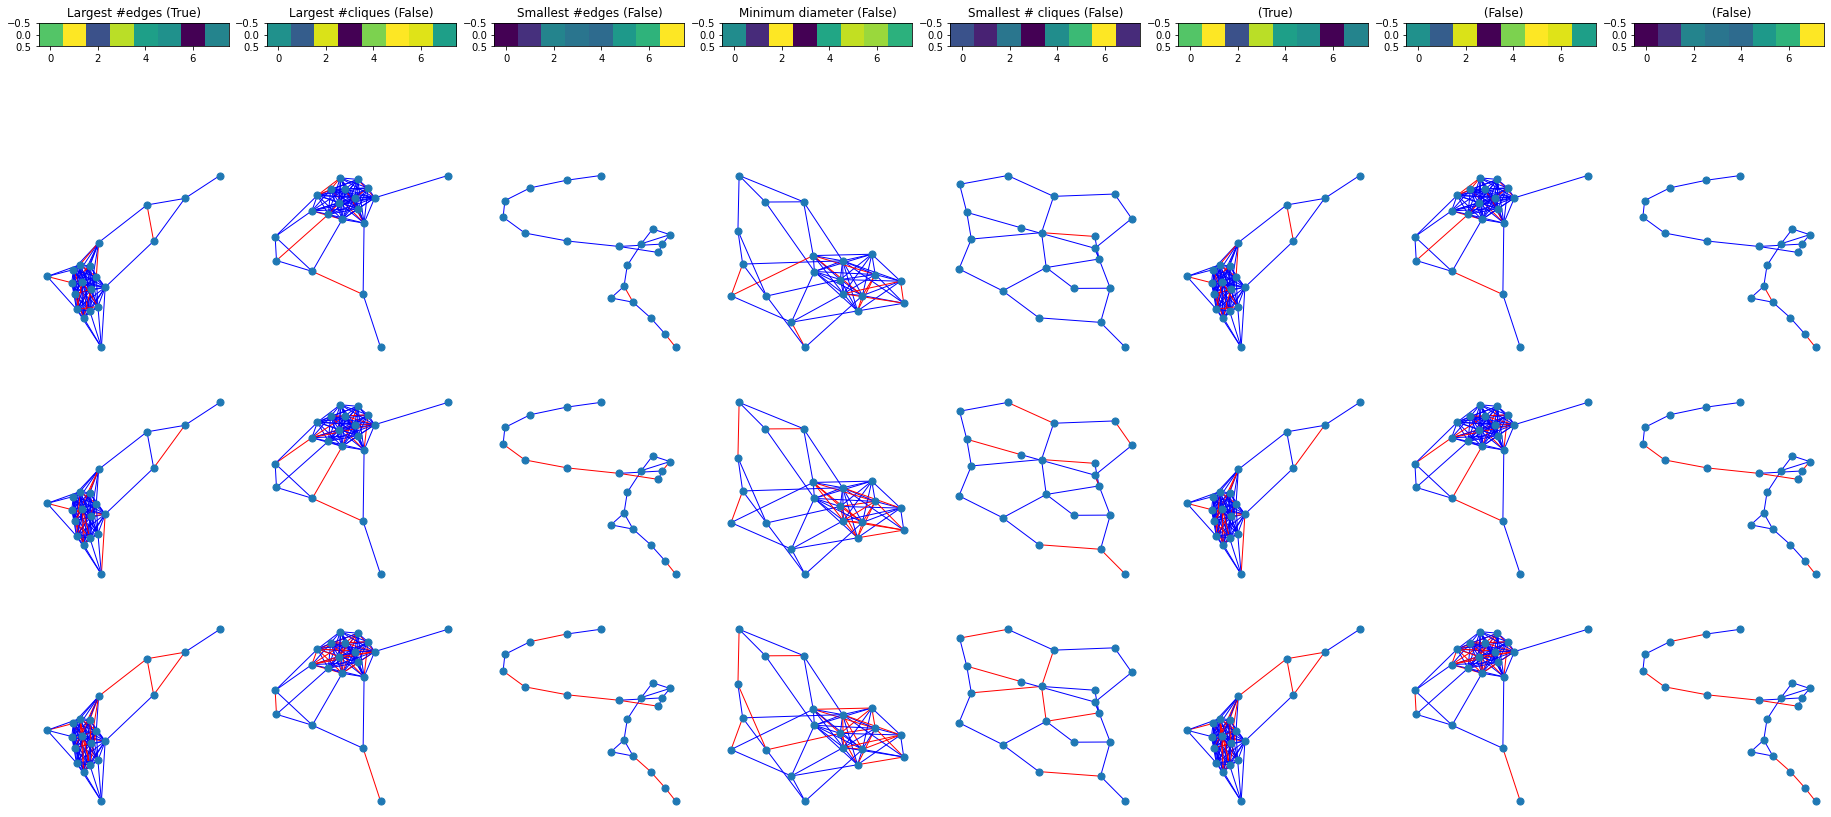

In [57]:
ind = [4175, 585, 94, 584, 1792, 
       list(ind)[0], list(ind)[1], list(ind)[2]]
ind_title = ["Largest #edges", "Largest #cliques", "Smallest #edges", "Minimum diameter", 
             "Smallest # cliques", "", "", ""]
#ind = [4005, 94, 1792, y_train.index[0], y_train.index[1], y_train.index[2], y_train.index[3], y_train.index[4]]

ncol = 8
nrow = 4
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
num_nodes=20

for i in range(8):
    model = LogitRegression(learning_rate = 0.01, iterations = 1000)
    x = np.array([np.matmul(results_dict_new["loading"][0].T, 
                            X_train[list(y_train.index).index(ind[i]),:].T).T])
    model.fit(x, np.array(y_train[ind[i]])) 
    W = np.array(model.W)
    print(np.array(y_train[ind[i]]), ": ", model.predict(x))
    print(np.array(df_dynamics)[ind[i], -20:])
    #print()
    
    axs[i//ncol, i%ncol].title.set_text(ind_title[i]+" ("+str(np.array(y_train[ind[i]])) + ")")
    axs[i//ncol, i%ncol].imshow(np.array([model.W[coef_idx]]))
    
    df_adj = df_graph[:, ind[i]].reshape(20, 20)
    #df_adj = np.array(X)[ind[i],:400].reshape(-1, 20)
    G = nx.Graph()
    G = nx.from_pandas_adjacency(pd.DataFrame(df_adj))
    
    iter = [1, 20, 50]
    for j in range(3):
        col_adj = X_train[list(y_train.index).index(ind[i]), 
                          (0+iter[j]*400):(400+iter[j]*400)].reshape(-1, num_nodes)
        
        
        
        x_t = np.array([np.matmul(results_dict_new["loading"][0][(0+iter[j]*400):(400+iter[j]*400),:].T,
                                  X_train[list(y_train.index).index(ind[i]), (0+iter[j]*400):(400+iter[j]*400)].T).T])
        """
        model = LogitRegression(learning_rate = 0.01, iterations = 1000)
        model.fit(x_t, np.array(y_train[ind[i]])) 
        print(model.predict_prob(x_t))
        """
        
        print(model.predict_prob(x_t))
        
        G1 = nx.Graph()
        for a in range(num_nodes):
            for b in range(num_nodes):
                u = list(G.nodes())[a]
                v = list(G.nodes())[b]
                if G.has_edge(u,v) and u!=v:
                    if abs(col_adj[u, v])==0: #< 0.03: #all synchronizing edges
                        G1.add_edge(u,v, color='r')
                    else:
                        G1.add_edge(u,v, color='b')
        
        edges = G1.edges()
        colors = [G1[u][v]['color'] for u,v in edges]
        nx.draw(G1, edge_color=colors, node_size= 50, ax=axs[i//ncol+1+j, i%ncol], pos = nx.spring_layout(G1, seed=123))